In [59]:
import math
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from tqdm import tqdm

In [60]:
#ハイパラ
input_dim = 9216
hidden_dim = 200  # ニューラルネットワークの中間層の次元数
latent_dim = 28
output_dim = 28
epochs = 30
learning_rate = 3e-4
batch_size = 1024
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [61]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
        )
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_sigma = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.linear(x)
        x = F.relu(x)
        mu = self.linear_mu(x)
        sigma = self.linear_sigma(x)
        return mu, sigma

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, 64, kernel_size=3, stride=3, padding=1, output_padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=3, padding=1, output_padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=3, padding=1, output_padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=3, padding=1, output_padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1),
            nn.Upsample(28)
        )
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        
    def forward(self, z):
        z=self.linear1(z)
        z=z.view(-1, z.size(1), 1, 1)
        h = self.conv(z)
        x_hat = F.sigmoid(h)
        return x_hat

In [62]:
def reparameter(mu, sigma):
    eps = torch.randn_like(sigma)
    return mu + eps * sigma

In [63]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, output_dim)
    
    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameter(mu, sigma)
        x_hat = self.decoder(z)
        L1 = F.mse_loss(x, x_hat, reduction='sum')
        L2 = torch.sum(mu**2 + sigma**2 - torch.log(sigma**2) - 1)
        return (L1 + L2)/batch_size

In [64]:

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])


dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
#dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [65]:

# ②モデルとオプティマイザ
model = VAE(input_dim, hidden_dim, latent_dim)
model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

# ③学習ループ
for epoch in (range(epochs)):
    loss_sum = 0.0
    cnt = 0

    for x, label in tqdm(dataloader):
        x = x.to(device)
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print("epoch:",epoch," ",loss_avg)

  0%|          | 0/59 [00:00<?, ?it/s]

100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


epoch: 0   941.9612726761123


100%|██████████| 59/59 [00:07<00:00,  8.00it/s]


epoch: 1   779.5148196462858


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


epoch: 2   700.7406104136321


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


epoch: 3   676.6456360897776


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


epoch: 4   658.2984174308131


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


epoch: 5   639.2265625


100%|██████████| 59/59 [00:07<00:00,  8.43it/s]


epoch: 6   621.5846433477886


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


epoch: 7   606.8111489506091


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


epoch: 8   597.7345229326669


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


epoch: 9   586.3266508458024


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


epoch: 10   569.3545128773835


100%|██████████| 59/59 [00:07<00:00,  8.43it/s]


epoch: 11   551.5677836789923


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


epoch: 12   536.5138301526085


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


epoch: 13   523.0164246639963


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


epoch: 14   533.0024610616393


100%|██████████| 59/59 [00:06<00:00,  8.45it/s]


epoch: 15   518.0199067713851


100%|██████████| 59/59 [00:06<00:00,  8.50it/s]


epoch: 16   513.6659132100768


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


epoch: 17   515.4700550144001


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


epoch: 18   502.55841478250795


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


epoch: 19   502.89335916810114


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


epoch: 20   500.0078492245432


100%|██████████| 59/59 [00:06<00:00,  8.43it/s]


epoch: 21   493.79246908931407


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


epoch: 22   494.3021395408501


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


epoch: 23   488.90410497633076


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


epoch: 24   486.1733201883607


100%|██████████| 59/59 [00:07<00:00,  8.33it/s]


epoch: 25   482.663008350437


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


epoch: 26   479.8468834828522


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


epoch: 27   477.27476268703657


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


epoch: 28   475.08204728465967


100%|██████████| 59/59 [00:06<00:00,  8.47it/s]

epoch: 29   473.0740977141817


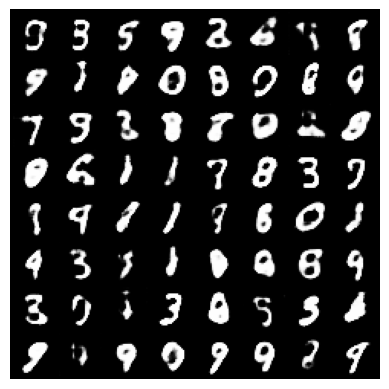

In [66]:
with torch.no_grad():  # ①
    sample_size = 64
    z = torch.randn(sample_size, latent_dim).to(device)  # ②[32, 64, 12, 28]
    x = model.decoder(z)  # ③
    generated_images = x.view(sample_size, 1, 28, 28)  # ④

# ⑤
grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)

plt.imshow(grid_img.permute(1, 2, 0).cpu())
plt.axis("off")
plt.show()